In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import os
import sys
import copy
import gc
import datetime
import random
import math
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics.engine.results import Results
from ultralytics.models.yolo.detect.predict import DetectionPredictor
from ultralytics.utils import DEFAULT_CFG, ops

# AMP imports
from torch.cuda.amp import autocast

# Make sure you have installed ultralytics and pytorch_grad_cam properly
sys.path.append(r'C:\Users\nam.nguyen\Project\ultralytics')
from ultralytics import YOLO

## Load Model and override segmentation class to get raw output  

In [4]:
# Load YOLOv11 segmentation model with extra large architecture pretrained on COCO dataset
model_path = r"C:\Users\nam.nguyen\Project\models\yolo11x-seg.pt"


In [9]:
from ultralytics.utils import ASSETS
from ultralytics.models.yolo.segment.predict import SegmentationPredictor
from ultralytics.engine.results import Results
from ultralytics.models.yolo.detect.predict import DetectionPredictor
from ultralytics.utils import DEFAULT_CFG, ops

args = dict(model=model_path, source=ASSETS)

In [6]:
class RawSegmentationPredictor(SegmentationPredictor):
    def construct_result(self, pred, img, orig_img, img_path, proto):
        """
        Constructs the result object from the prediction.

        Args:
            pred (np.ndarray): The predicted bounding boxes, scores, and masks.
            img (torch.Tensor): The image after preprocessing.
            orig_img (np.ndarray): The original image before preprocessing.
            img_path (str): The path to the original image.
            proto (torch.Tensor): The prototype masks.

        Returns:
            (Results): The result object containing the original image, image path, class names, bounding boxes, and masks.
        """
        if not len(pred):  # save empty boxes
            masks = None
        elif self.args.retina_masks:
            pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
            masks = ops.process_mask_native(proto, pred[:, 6:], pred[:, :4], orig_img.shape[:2])  # HWC
        else:
            self.pred = pred
            self.proto_mask = proto
            masks = ops.process_mask(proto, pred[:, 6:], pred[:, :4], img.shape[2:], upsample=True)  # HWC
            pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)

            
        if masks is not None:
            keep = masks.sum((-2, -1)) > 0  # only keep preds with masks
            pred, masks = pred[keep], masks[keep]
        return Results(orig_img, path=img_path, names=self.model.names, boxes=pred[:, :6], masks=masks)

# Instantiate your custom predictor with the same arguments.
raw_predictor = RawSegmentationPredictor(overrides=args)

In [10]:
raw_predictor.setup_model(model=model_path,verbose=True)

Ultralytics 8.3.94  Python-3.11.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA T1000 8GB, 8192MiB)
YOLO11x-seg summary (fused): 203 layers, 62,094,528 parameters, 0 gradients, 319.0 GFLOPs


In [11]:
image_path = r"C:\Users\nam.nguyen\Project\yolo-coefficient-visualizations\data\000000000285.jpg"  
result_raw = raw_predictor.predict_cli(source=image_path)


image 1/1 C:\Users\nam.nguyen\Project\yolo-coefficient-visualizations\data\000000000285.jpg: 640x608 1 bear, 162.0ms
Speed: 2.5ms preprocess, 162.0ms inference, 121.3ms postprocess per image at shape (1, 3, 640, 608)
Results saved to runs\detect\train


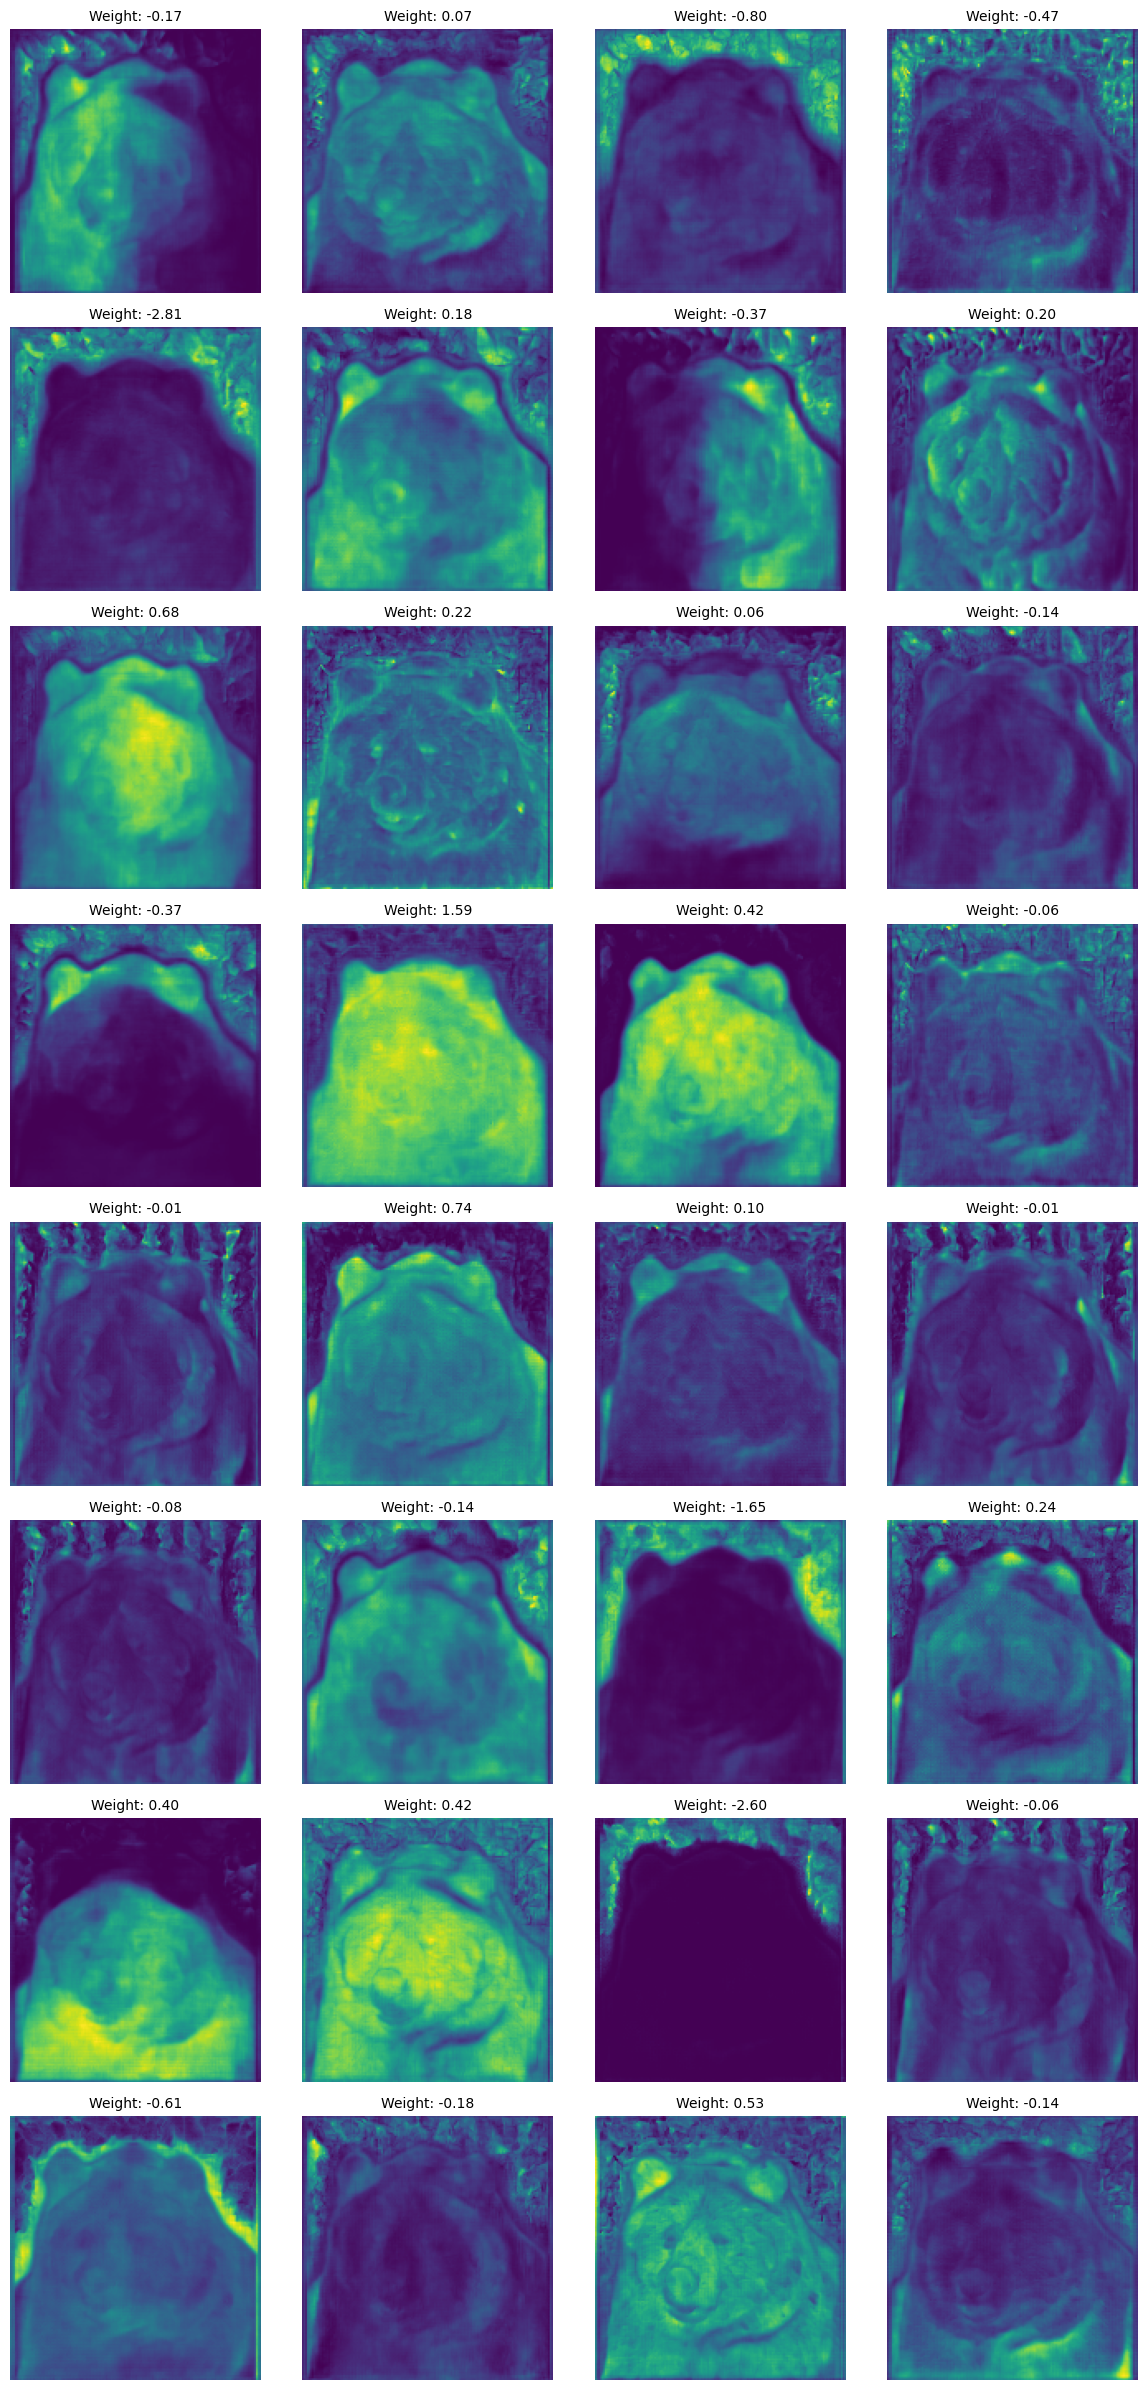

In [13]:
import matplotlib.pyplot as plt

# Extract the first image's prototype masks and mask weights, and move them to CPU.
proto_masks = raw_predictor.proto_mask.cpu().numpy()  # shape: (32, H, W)
mask_weights = raw_predictor.pred[:, 6:].cpu().numpy()[0]  # shape: (32,)

# Determine grid layout for 32 prototypes (e.g., 4 columns and 8 rows)
n_protos = proto_masks.shape[0]
cols = 4
rows = n_protos // cols if n_protos % cols == 0 else (n_protos // cols) + 1

# Create subplots to display each mask with its corresponding weight.
fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axs = axs.flatten()  # Flatten the axes for easy iteration

for i in range(n_protos):
    ax = axs[i]
    ax.imshow(proto_masks[i])  # Display the mask
    ax.set_title(f'Weight: {mask_weights[i]:.2f}', fontsize=10)
    ax.axis('off')  # Hide axes for clarity

# Hide any extra subplots if present.
for j in range(n_protos, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### Explanation of `raw_predictor`, `proto_masks`, and `mask_weights`

The code snippet extracts two key elements from the model's output (referred to as `raw_predictor`) when performing instance segmentation with a YOLO-based model that leverages ideas from YOLACT.

#### `raw_predictor`
- **What it is:**  
  `raw_predictor` is an output object from the model containing various prediction results, including bounding boxes, class scores, and segmentation-related outputs.
- **Segmentation Outputs:**  
  In the context of instance segmentation, it holds:
  - **`proto_mask`:** A set of prototype masks for the entire image.
  - **`pred`:** Prediction vectors where part of the vector (from index 6 onward) represents the mask coefficients for each detected instance.

#### `proto_masks`
- **Definition:**  
  The variable `proto_masks` is obtained from `raw_predictor.proto_mask` and represents a collection of prototype masks.
- **Shape:**  
  It has the shape `(32, H, W)`, which means there are 32 prototype masks, each with a spatial dimension of height `H` and width `W`.
- **Purpose:**  
  These prototypes serve as a basis for constructing instance-specific masks. They are computed once per image and shared across all detections, which makes the segmentation process more efficient.

#### `mask_weights`
- **Definition:**  
  The variable `mask_weights` is derived from the prediction tensor (`raw_predictor.pred`) by selecting columns from index 6 onward, and then taking the first detection's coefficients.
- **Shape:**  
  It has the shape `(32,)`, corresponding to 32 coefficients—one per prototype mask.
- **Purpose:**  
  For each detected instance, these coefficients are used to linearly combine the 32 prototype masks. The final instance mask is computed as:
  
  $$
  \text{Instance Mask} = \sum_{i=1}^{32} (\text{mask\_weight}_i \times \text{proto\_mask}_i)
  $$

This design is inspired by the YOLACT approach, where generating a set of shared prototype masks and per-instance mask coefficients allows for real-time instance segmentation without the need to compute an entirely separate mask for every detection.

For further details, refer to:
- [YOLACT: Real-Time Instance Segmentation](https://openaccess.thecvf.com/content_ICCV_2019/papers/Bolya_YOLACT_Real-Time_Instance_Segmentation_ICCV_2019_paper.pdf)
- [GitHub Discussion on YOLO Instance Segmentation](https://github.com/ultralytics/ultralytics/issues/2953)


### Explanation of the Image and Coefficients

The image above displays 32 prototype masks (proto masks) extracted from the model, along with their corresponding weights. These weights (coefficients) are used to combine the proto masks into the final instance segmentation mask.

#### What the Image Shows:
- **32 Prototype Masks:**  
  Each subplot represents one of the learned prototype masks for the entire image. These masks capture different spatial features that the network has learned during training.

- **Weight Annotations:**  
  Each mask is labeled with a coefficient (e.g., `Weight: 0.37`). These coefficients indicate the contribution of each prototype mask to the final instance mask, which is computed as:
  
  $$
  \text{Instance Mask} = \sum_{i=1}^{32} (\text{mask\_weight}_i \times \text{proto\_mask}_i)
  $$

#### Positive and Negative Coefficients:
- **Positive Coefficients:**  
  A positive weight means the corresponding prototype mask is added to the final segmentation mask, highlighting the regions where the mask should be active.

- **Negative Coefficients:**  
  A negative weight indicates that the prototype mask is subtracted or suppressed in certain regions. This helps the model remove noise or unwanted areas (such as parts of the background) from the final mask.

- **Flexibility in Mask Formation:**  
  Allowing both positive and negative coefficients enables the network to create more accurate and refined segmentation masks. The model can emphasize important features and cancel out irrelevant parts, leading to better overall segmentation performance.

#### Importance for YOLO-Based Instance Segmentation:
1. **Efficiency:**  
   The use of a fixed set of prototype masks means that the network only needs to generate these masks once per image. For each detected instance, it only computes a set of coefficients, which is computationally efficient and supports real-time performance.

2. **Interpretability:**  
   Analyzing these prototypes and their coefficients provides valuable insights into how the network combines features to generate segmentation masks. This helps in understanding and debugging the model.

3. **Scalability:**  
   Since the same set of prototype masks is reused for different instances, the model scales well with the number of detections in an image.

4. **Real-Time Segmentation:**  
   Inspired by YOLACT, this approach balances speed and accuracy, making it suitable for applications that require real-time instance segmentation.
